In [134]:
path = '../bayes_implicit_solvent/data/hydrogen_or_not_langevin_freesolv_n_config=5_job_id=730_gaussian_ll.npz'

In [135]:
import numpy as np
result = np.load(path)

In [136]:
result['stepsize']

array(1.e-07)

In [137]:
list(result.keys())

['traj', 'stepsize', 'log_probs', 'collision_rate', 'n_steps', 'gaussian_ll']

In [138]:
traj = result['traj']

In [139]:
log_probs = result['log_probs']

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

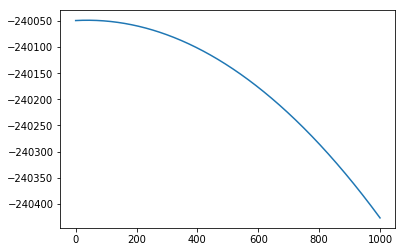

In [141]:
plt.plot(log_probs)

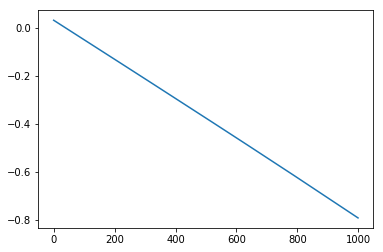

In [142]:
plt.plot(np.diff(log_probs))

In [143]:
traj.shape

(1001, 4)

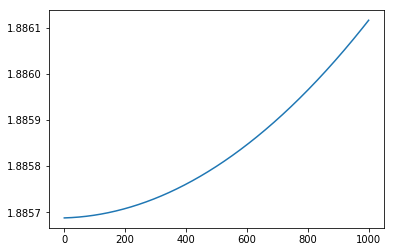

In [144]:
plt.plot(traj[:,0])

In [145]:
sum(np.diff(traj[:,0]) != 0)

1000

In [146]:
sum(np.diff(traj[:,1]) != 0)

1000

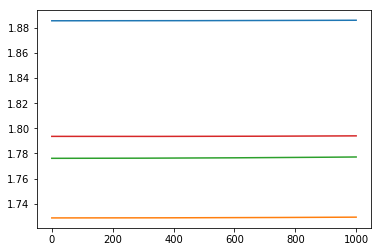

In [147]:
for t in traj.T:
    plt.plot(t)

In [148]:
traj[-1] - traj[0]

array([0.00042928, 0.00060829, 0.00106154, 0.00040168])

In [149]:
max(log_probs)

-240048.55299823664

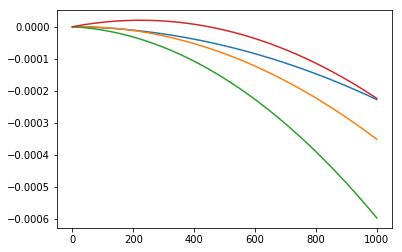

In [150]:
for t in traj.T:
    plt.plot(1 - (t / t[0]))

In [151]:
traj[-1]

array([1.88611684, 1.72926185, 1.7771905 , 1.79401411])

In [152]:
log_probs[1000]

-240427.17440165716

In [153]:
traj[-1]

array([1.88611684, 1.72926185, 1.7771905 , 1.79401411])

In [154]:
from sklearn.decomposition import PCA
pca = PCA()

In [155]:
pca.fit(traj)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

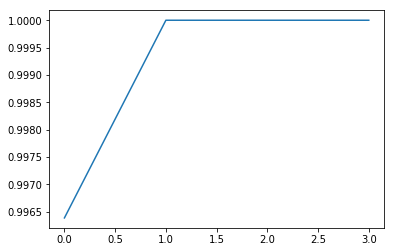

In [156]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [157]:
y = pca.transform(traj)

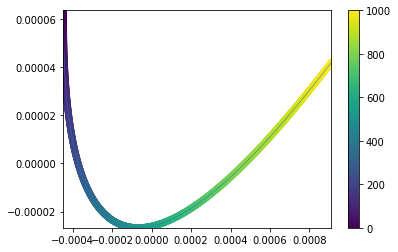

In [158]:
plt.plot(y[:,0], y[:,1], linewidth=0.5)
plt.scatter(y[:,0], y[:,1], c=np.arange(len(y)))
plt.xlim(min(y[:,0]), max(y[:,0]))
plt.ylim(min(y[:,1]), max(y[:,1]))
plt.colorbar()

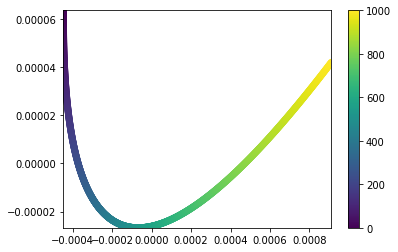

In [159]:
plt.scatter(y[:,0], y[:,1], c=np.arange(len(y)))
plt.xlim(min(y[:,0]), max(y[:,0]))
plt.ylim(min(y[:,1]), max(y[:,1]))
plt.colorbar()

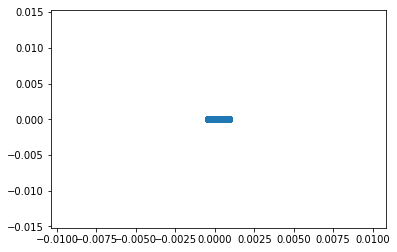

In [160]:
plt.scatter(y[:,0], y[:,1])

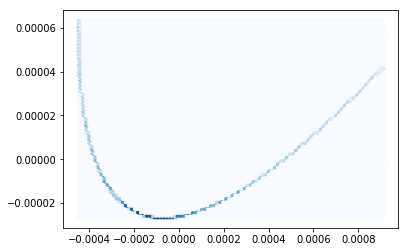

In [161]:
plt.hexbin(y[:,0], y[:,1], cmap='Blues')

In [162]:
from bayes_implicit_solvent.molecule import Molecule

In [163]:
from pkg_resources import resource_filename
import mdtraj as md
from bayes_implicit_solvent.utils import mdtraj_to_list_of_unitted_snapshots
alkanes = ['C' * i for i in range(1, 11)]

mols = []
hydrogens = []

n_configuration_samples = 100

for smiles in alkanes:
    mol = Molecule(smiles, vacuum_samples=[])
    path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                               'vacuum_samples/vacuum_samples_{}.h5'.format(
                                                   mol.mol_index_in_smiles_list))
    vacuum_traj = md.load(path_to_vacuum_samples)
    thinning = int(len(vacuum_traj) / n_configuration_samples)
    mol.vacuum_traj = mdtraj_to_list_of_unitted_snapshots(vacuum_traj[::thinning])
    print('thinned vacuum_traj from {} to {}'.format(len(vacuum_traj), len(mol.vacuum_traj)))
    hydrogens.append(np.array([a.element.symbol == 'H' for a in mol.top.atoms()]))
    mols.append(mol)

thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100
thinned vacuum_traj from 10000 to 100


In [164]:
def unpack(theta):
    n = int((len(theta)) / 2)
    radii, scales = theta[:n], theta[n:2 * n]
    return radii, scales

In [165]:
radii, scales = unpack(traj[-1])

In [166]:
radii

array([1.88611684, 1.72926185])

In [167]:
scales

array([1.7771905 , 1.79401411])

In [168]:
elements = []
all_elements = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]
element_dict = dict(zip(all_elements, list(range(len(all_elements)))))
for mol in mols:
    elements.append(np.array([a.element.atomic_number for a in mol.top.atoms()]))

In [169]:
def construct_array(i, theta):
    radii, scales = unpack(theta)

    mol_radii = np.array([radii[element_dict[element]] for element in elements[i]])
    mol_scales = np.array([scales[element_dict[element]] for element in elements[i]])
    return mol_radii, mol_scales

def construct_arrays(theta):
    arrays = [construct_array(i, theta) for i in range(len(mols))]
    mol_radii = [a[0] for a in arrays]
    mol_scales = [a[1] for a in arrays]
    return mol_radii, mol_scales
mol_radii, mol_scales = construct_arrays(traj[-1])

In [170]:
mol = mols[0]
radii = mol_radii[0]
scales = mol_scales[0]

In [171]:
mol.predict_solvation_free_energy(radii, scales)

(-6.870019034543873e-06, 3.841297727171263e-14)

In [172]:
mol.experimental_value, mol.experimental_uncertainty

(3.375609170943315, 0.3375609170943315)

In [173]:
thinned_traj = traj[::10]
len(thinned_traj)

101

In [174]:
all_pred_means = []
all_pred_uncs = []

expt_means, expt_uncs = [], []
for i in range(len(mols)):
    mol = mols[i]
    expt_mean, expt_unc = mol.experimental_value, mol.experimental_uncertainty
    
    expt_means.append(expt_mean)
    expt_uncs.append(expt_unc)

for i in range(len(mols)):
    mol = mols[i]
    expt_mean, expt_unc = mol.experimental_value, mol.experimental_uncertainty
    
    pred_means, pred_uncs = [], []
    
    for t in thinned_traj:
        mol_radii, mol_scales = construct_arrays(t) 
        radii = mol_radii[i]
        scales = mol_scales[i]

        pred_mean, pred_unc = mol.predict_solvation_free_energy(radii, scales)
        pred_means.append(pred_mean)
        pred_uncs.append(pred_unc)
    all_pred_means.append(np.array(pred_means))
    all_pred_uncs.append(np.array(pred_uncs))

In [175]:
expt_means, expt_uncs = [], []
for i in range(len(mols)):
    mol = mols[i]
    expt_mean, expt_unc = mol.experimental_value, mol.experimental_uncertainty
    
    expt_means.append(expt_mean)
    expt_uncs.append(expt_unc)

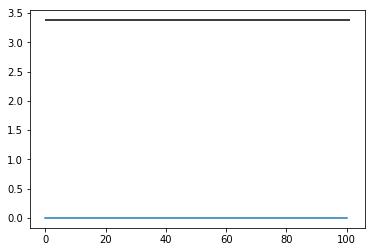

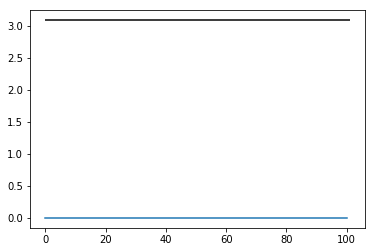

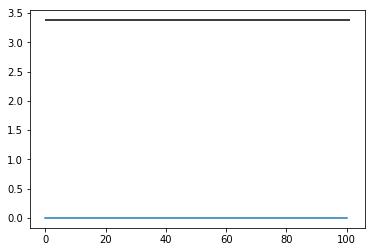

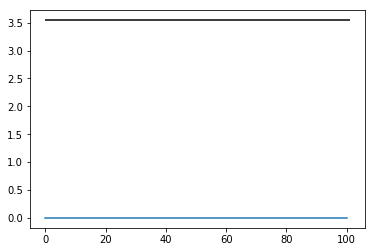

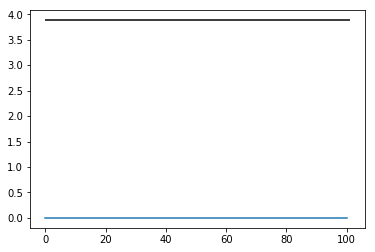

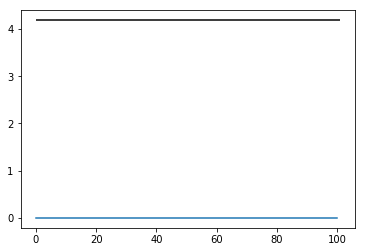

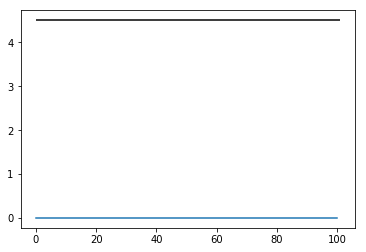

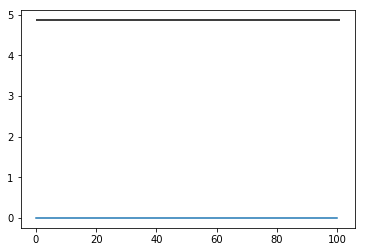

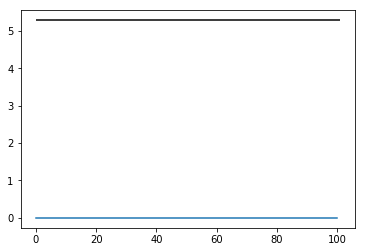

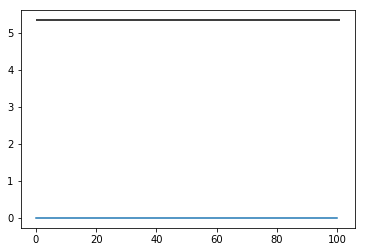

In [176]:
for i in range(len(mols)):
    plt.figure()
    plt.plot(all_pred_means[i])
    plt.hlines(expt_means[i], 0, len(all_pred_means[i]))

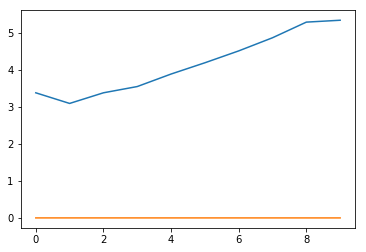

In [177]:
plt.plot(expt_means)
plt.plot(list(map(np.mean, all_pred_means)))

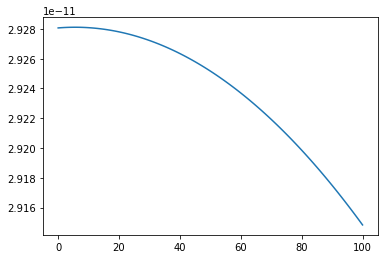

In [178]:
plt.plot(all_pred_uncs[-1])

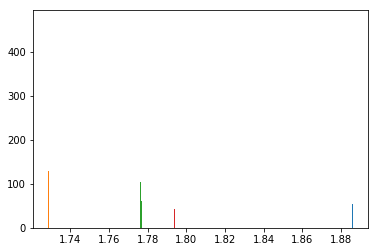

In [179]:
for t in traj.T:
    plt.hist(t)